<a href="https://colab.research.google.com/github/tehseendahya/Energy_predict_xgboost/blob/main/Energy_Predict(XGBoost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# customize the style
#pd.options.display.float_format = '{:.5f}'.format
#pd.options.display.max_rows = 12


import xgboost as xgb
#Give us more penalty for data that is way off
from sklearn.metrics import mean_squared_error, mean_absolute_error
#shows the color palette from the seaborn library. It is an array of colors
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
df = pd.read_csv('/PJME_hourly.csv')
df = df.set_index('Datetime')
#dataype is just an object type, so here we cast it to a DateTime object. Without this, the x axis would look terrible as it would be a string
df.index = pd.to_datetime(df.index)

In [6]:
#just test to see the first few rows
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


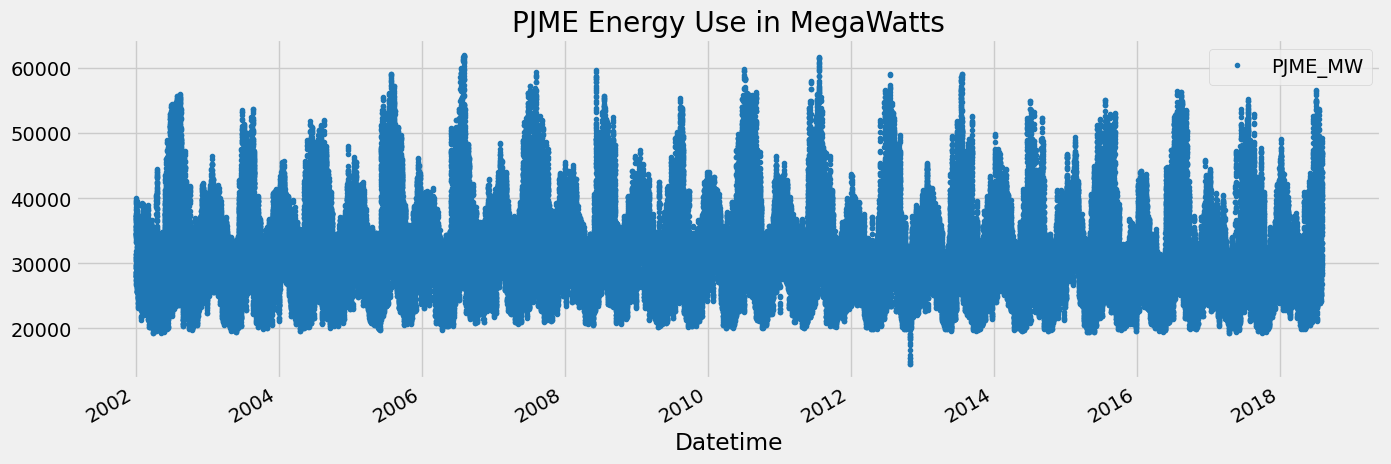

In [8]:
#can be styled with many different objects. here it is a dot
df.plot(style='.',
        figsize=(15, 5),
        #picking first color in seaborn color palette
        color=color_pal[0],
        title='PJME Energy Use in MegaWatts')
plt.show()

## Train/test split

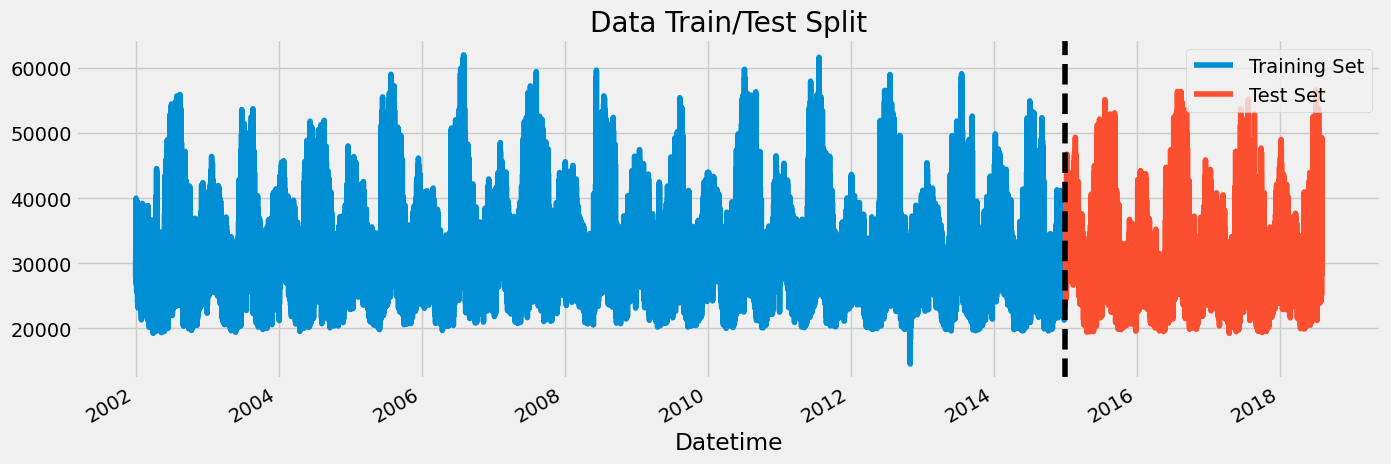

In [9]:
#we are not doing cross validation in this one, but we could do it for a more difficult version

#everything before Jan 2015 is training, everything after is test
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

#plotts both test and train in same slot
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
#line splits test and train
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
#legend to show difference
ax.legend(['Training Set', 'Test Set'])
plt.show()

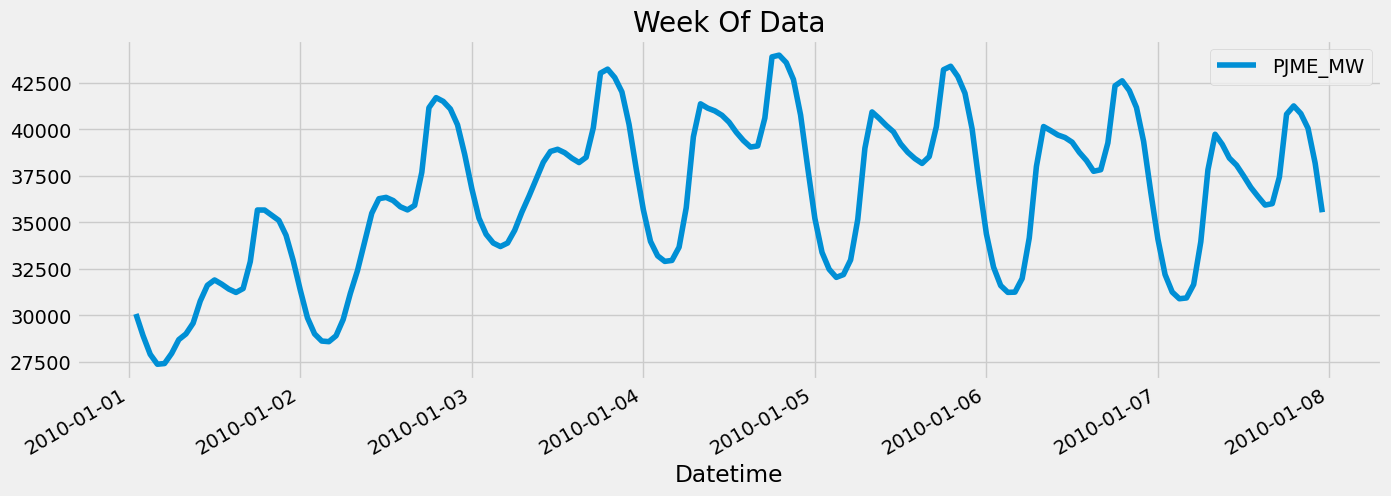

In [10]:
#just show one week of data from training set

df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

#we can see the peaks during day and valleys at night. Also see a weekend effect and lower peaks on holidays (jan 1)

##Feature Creation


In [11]:
#pandas makes this very easy
#For days of week, Monday is a 0 and Sunday is a 6

#Creating features using DateTime index
def create_features(df):
    """
    Create time series features based on time series index.
    """

    #To edit a copy of our dataframe and not the real one when we create features for test
    df = df.copy()
    #we can literally make an hour column in dataset with pandas
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

##Visualize our Feature/Target Relationshio

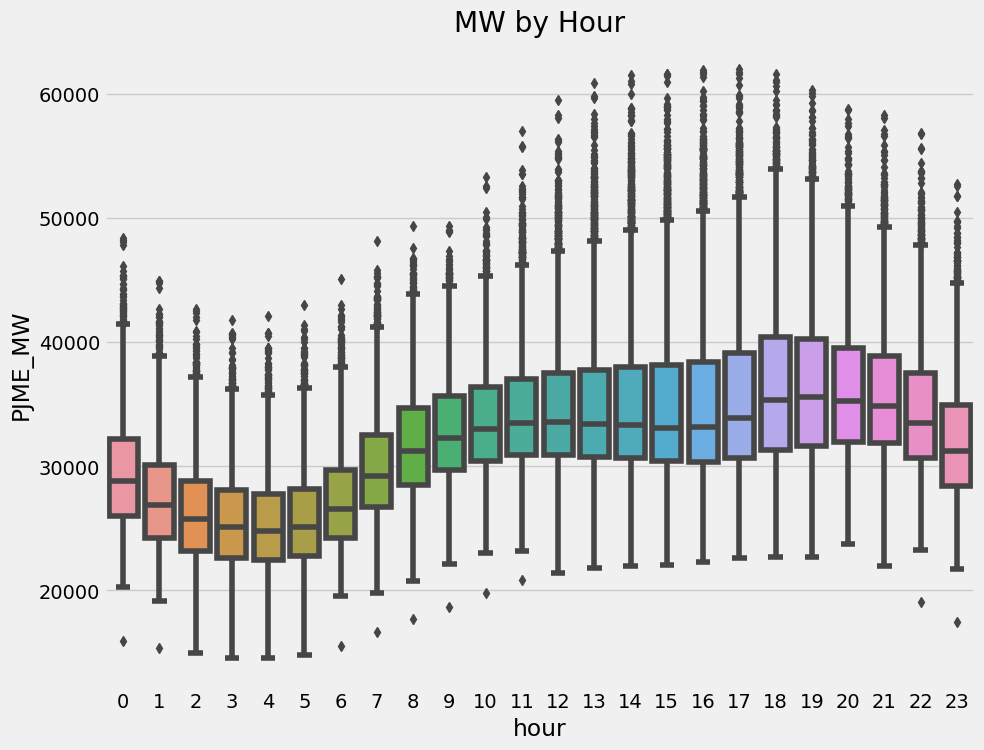

In [12]:
#Use seaborn's boxplot
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

#Early in morning there is a dip and it increases throughout the day

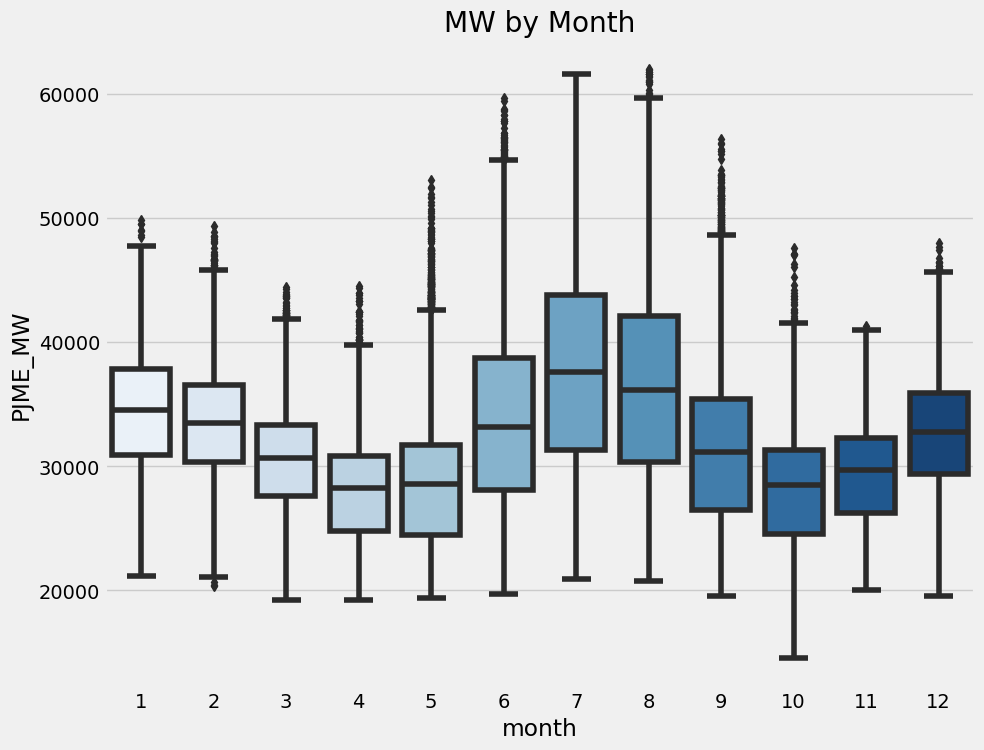

In [13]:
#same thing but for month

#Peak in summertime and winter

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

##Creating our model

In [14]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

#All training features
X_train = train[FEATURES]
#All targets
y_train = train[TARGET]

#same thing
X_test = test[FEATURES]
y_test = test[TARGET]

In [16]:
#Regression task so we use xgboost regressor which is good for regression and time series analysis

#Everything here is the tuning
reg = xgb.XGBRegressor(
                       #Initial prediction score of all instances
                       base_score=0.5,
                       #The boosting model is tree-based in this case
                       booster='gbtree',
                       #There will be 1000 boosting rounds (trees) built
                       n_estimators=1000,
                       #stops early if test set does not improve after 50 trees
                       early_stopping_rounds=50,
                       #The learning objective is to achieve a linear objective function
                       objective='reg:linear',
                       #Max depth of each tree
                       max_depth=3,
                       #make sure overfitting doesn't happen too quickly. Used in each boosting step
                       learning_rate=0.01)

#Fitting model to training set
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #print out the score every 100 trees that are built
        verbose=100)

#we can see the rmse (root mean squared error) getting smaller for both the training and validation sets. Early stopping stops it from overfitting and getting worse

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:21:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

##Feature Importance


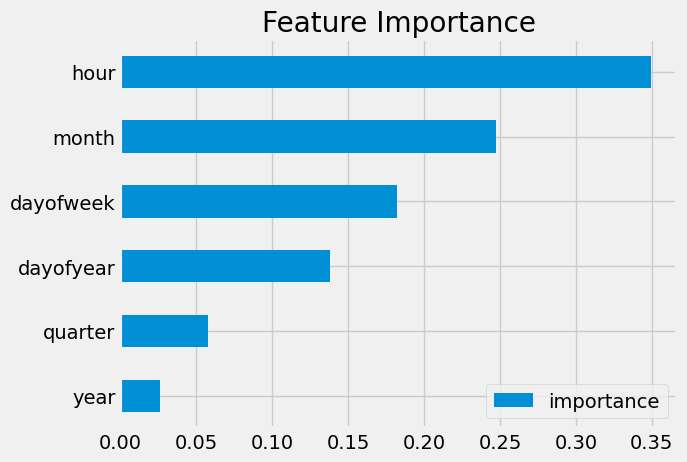

In [17]:
#Shows how much each feature was used in each of the trees built by the xbg model

#Only important line here is "reg.feature_importances_", but we put it into a df to visualize it

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#Possible issue is that there is some overlap between dayofyear and month as they are correlated. If we took out month from this, dayofyear would just replace it

##Forecast on the Test Set

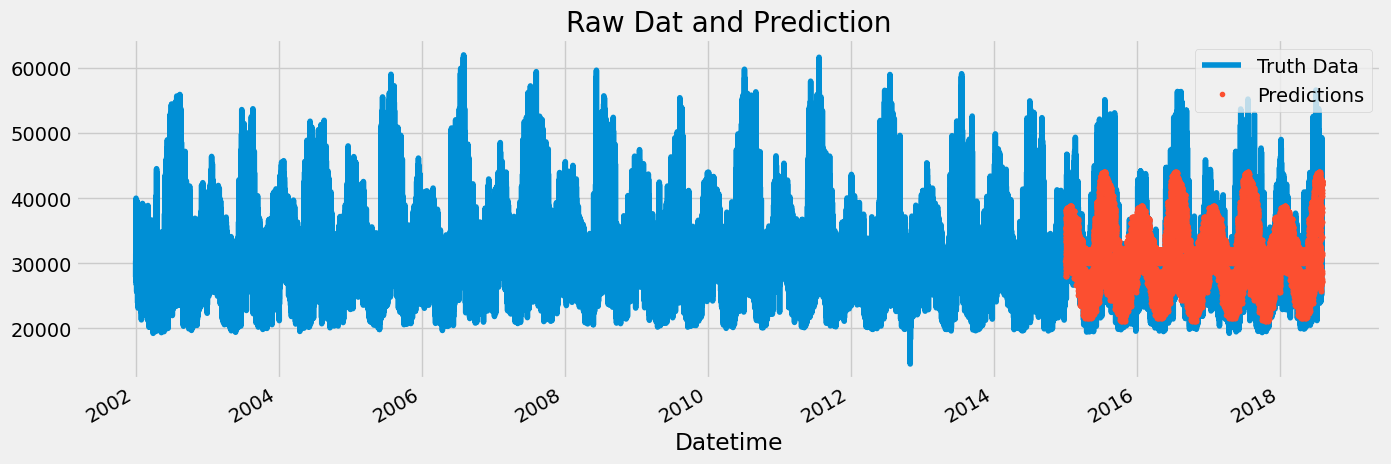

In [20]:
#This first line will output a numpy array of all the predictions for the testset
test['prediction'] = reg.predict(X_test)

#We then merge these predictions to be next to the training data. We merge the two dataframes on the index columns
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])

#Need to fix the title
ax.set_title('Raw Dat and Prediction')
plt.show()

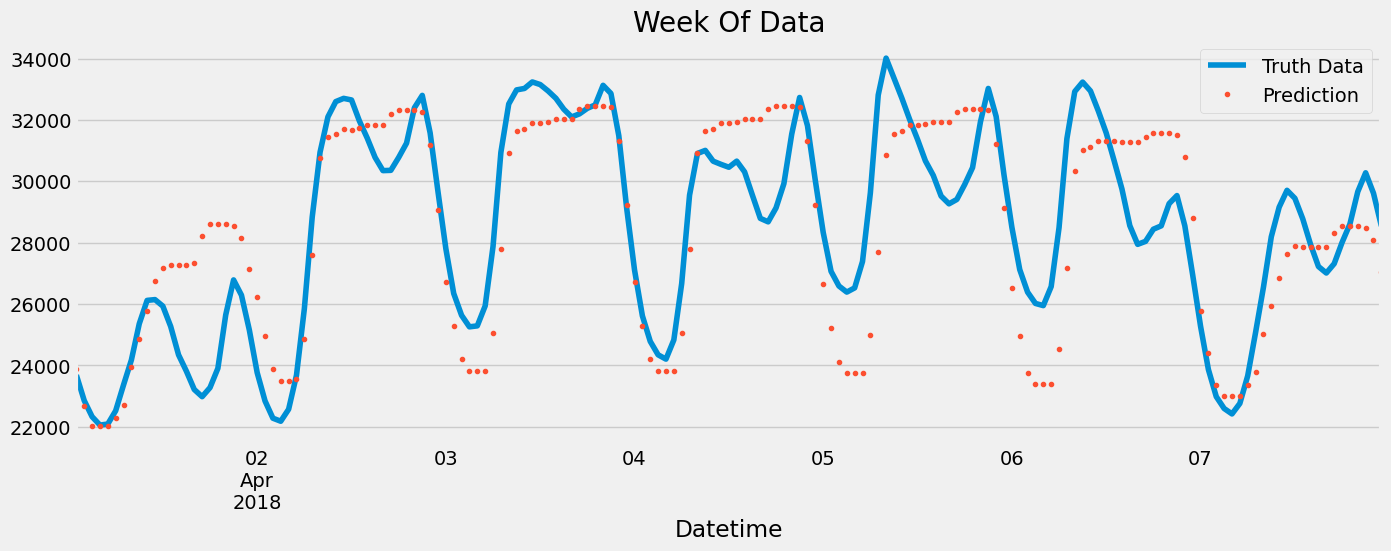

In [21]:
#Now look at one week like we did before

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

#Data isn't amazing. We did not do any parameter tuning at all so it isn't great

In [22]:
#Score (Root mean squared error)

#this RMSE is the same as the lowest one on the test set above. Makes sense

score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


In [23]:
#MAE

MAE = mean_absolute_error(test['PJME_MW'], test['prediction'])

print(f'This is the Mean Absolute Error (MAE): {MAE:.2f}')

This is the Mean Absolute Error (MAE): 2902.29


In [24]:
#MAPE
MAPE = mean_absolute_percentage_error(test['PJME_MW'], test['prediction'])

print(f'This is the Mean Absolute Percentage Error (MAPE): {MAPE:.2f}')

This is the Mean Absolute Percentage Error (MAPE): 9.16


##Calculate Error

In [25]:
#Worst predicted days

test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
Name: error, dtype: float64

In [26]:
#Best predicted days

test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2017-10-24    322.958008
2015-10-28    426.451335
2016-10-27    543.167155
2015-05-06    556.749674
2017-10-15    569.468262
Name: error, dtype: float64

##Next steps

- More robust cross validation
- More features (feature, holidays, etc)
- More fine tuning